Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation F1 Score: 0.944358078748239
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


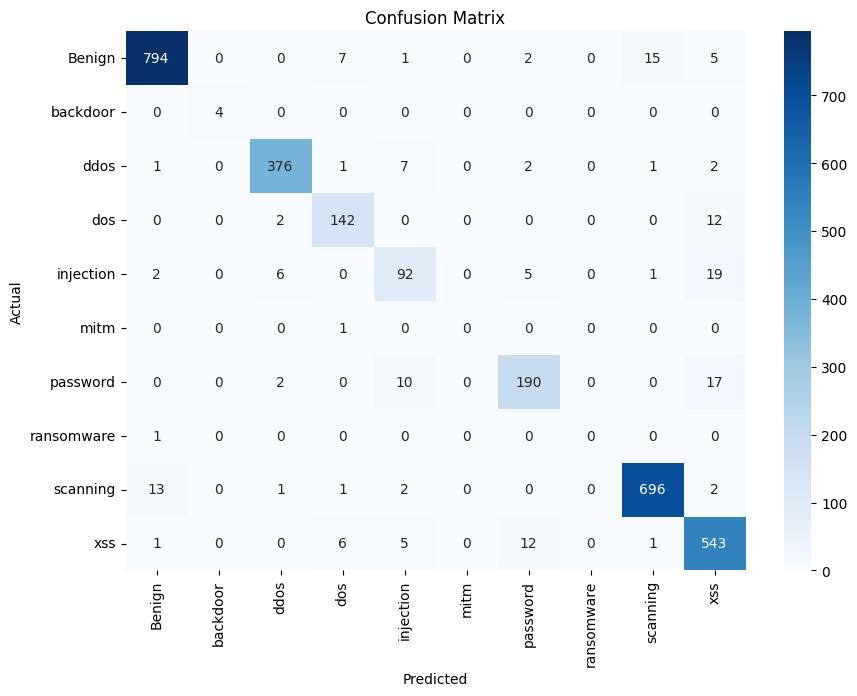

In [1]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load CSV files from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define file paths for training and testing datasets
train_file_path = '/content/drive/My Drive/IDS Dataset 2/NF-ToN-IoT-V2_15000 samples_minmax_normalized_train.csv'
test_file_path = '/content/drive/My Drive/IDS Dataset 2/NF-ToN-IoT-V2_15000 samples_minmax_normalized_test.csv'

# Load the datasets into DataFrames
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Separate features and labels for training and testing datasets
X_train = train_data.iloc[:, :-2]  # All columns except the last two (labels)
y_train = train_data.iloc[:, -1]  # Last column (label names)

X_test = test_data.iloc[:, :-2]   # All columns except the last two (labels)
y_test = test_data.iloc[:, -1]    # Last column (label names)

# Convert string labels to numeric using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBoost model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1_weighted', cv=5, n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train_encoded)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print best parameters and score
print("Best Parameters:", best_params)
print("Best Cross-Validation F1 Score:", grid_search.best_score_)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics on the test set
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

# Print evaluation metrics for test set
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [2]:
# Import necessary libraries
import os
import joblib
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path for the model and the folder name
model_folder = '/content/drive/My Drive/IDS models'
model_filename = 'best_model_xgboost'
model_path = os.path.join(model_folder, model_filename)

# Create the folder if it doesn't exist
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Save the model to the specified path
joblib.dump(best_model, model_path)

print(f'Model saved successfully at: {model_path}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved successfully at: /content/drive/My Drive/IDS models/best_model_xgboost


In [3]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, X_train, y_train_encoded ,cv = 10, scoring = 'recall_weighted')
avg_scores = scores.mean()
avg_scores



0.9453788509575356

In [4]:
from sklearn.model_selection import cross_val_score
scores_test = cross_val_score(best_model, X_test, y_test_encoded ,cv = 10, scoring = 'recall_weighted')
avg_scores_test = scores_test.mean()
avg_scores_test

nan

In [5]:
print("Unique classes in training data:", set(y_train_encoded))
print("Unique classes in test data:", set(y_test_encoded))


Unique classes in training data: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Unique classes in test data: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [6]:
print("Train score is:",format(avg_scores))
print("Test score is:",format(avg_scores_test))

Train score is: 0.9453788509575356
Test score is: nan


In [12]:
# یافتن کلاس‌های مشترک بین داده‌های آموزش و تست
common_classes = set(y_train_encoded).intersection(set(y_test_encoded))
print(f"Common classes: {common_classes}")

# فیلتر کردن داده‌های تست برای کلاس‌های مشترک
test_indices = [i for i, label in enumerate(y_test_encoded) if label in common_classes]
X_test_filtered = X_test.iloc[test_indices]
y_test_filtered = [y_test_encoded[i] for i in test_indices]

# بررسی کلاس‌های جدید در داده‌های تست
print(f"Classes in filtered test data: {set(y_test_filtered)}")


Common classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Classes in filtered test data: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [13]:
from sklearn.metrics import recall_score

y_pred_test = best_model.predict(X_test_filtered)
recall = recall_score(y_test_filtered, y_pred_test, average='weighted')
print("Recall (weighted) on test data:", recall)


Recall (weighted) on test data: 0.9447219447219447


In [14]:
print("Train score is:",format(avg_scores))
print("Test score is:",format(recall))

Train score is: 0.9453788509575356
Test score is: 0.9447219447219447
